In [1]:
%reload_ext autoreload
%autoreload 2
import pyxdf
import os
import numpy as np
from scipy import stats
from pathlib import Path
import sys
from datetime import datetime
import pandas as pd
import seaborn

from utilities.utl import find_lsl_stream, find_nearest, fill_nan
from utilities.pupil_prep import *
from utilities.SingleSubjectData import SubjectData, Epochs
import importlib


In [2]:
# (import) helper functions
dir_script = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_script.parent.absolute(), "04_data","00_raw")
print(dir_script)

c:\Users\User\Desktop\kiel\tremor_feedback_jw\05_scripts


In [3]:
f_list = os.listdir(dir_rawdata)
str_match = 'archer'
fnms = [s for s in f_list if str_match in s]
print([f.split('_')[0] for f in fnms])

['c300', 'c301', 'c302', 'c303', 'c304', 'c305', 'c306', 'c307', 'c308', 'c309', 'c310', 'p200', 'p201', 'p202', 'p203', 'p204', 'p205', 'p206', 'p207', 'p208', 'p209', 'p210', 'p211', 'p212', 'p213', 'p214', 'p215']


In [207]:
sub = SubjectData()
f = fnms[5]
sub.load_data(dir_rawdata,f)

    



Max force is 8067 something


In [5]:
eps = Epochs(sub,sub.eye["time_series"],times=sub.eye["time_stamps"], events=sub.mrk, srate = sub.srate_ppl)
idx_exp_start   = eps.events[eps.events["value"].str.match('block1')].index[0]
eps.epoch('end_trial', idx_start=idx_exp_start,tmin=-29,tmax=0)



In [11]:

ch_info = sub.eye["info"]["desc"][0]["channels"][0]
len(ch_info["channel"])

nms_ppl = []
for i,ch in enumerate(ch_info["channel"]):
    nms_ppl.append(ch_info["channel"][i].get('label')[0])





['confidence', 'norm_pos_x', 'norm_pos_y', 'gaze_point_3d_x', 'gaze_point_3d_y', 'gaze_point_3d_z', 'eye_center0_3d_x', 'eye_center0_3d_y', 'eye_center0_3d_z', 'eye_center1_3d_x', 'eye_center1_3d_y', 'eye_center1_3d_z', 'gaze_normal0_x', 'gaze_normal0_y', 'gaze_normal0_z', 'gaze_normal1_x', 'gaze_normal1_y', 'gaze_normal1_z', 'diameter0_2d', 'diameter1_2d', 'diameter0_3d', 'diameter1_3d']
Delete diameter velocity outliers (sliding window)
number of detected outliers:  6996
proportion of detected outliers: 0.49
Delete diameter velocity outliers (sliding window)
number of detected outliers:  7061
proportion of detected outliers: 0.49
Delete diameter velocity outliers (sliding window)
number of detected outliers:  6954
proportion of detected outliers: 0.48
Delete diameter velocity outliers (sliding window)
number of detected outliers:  6738
proportion of detected outliers: 0.47
Delete diameter velocity outliers (sliding window)
number of detected outliers:  7042
proportion of detected out

Text(0.02, 0.5, 'Pupil size [mm^3]')

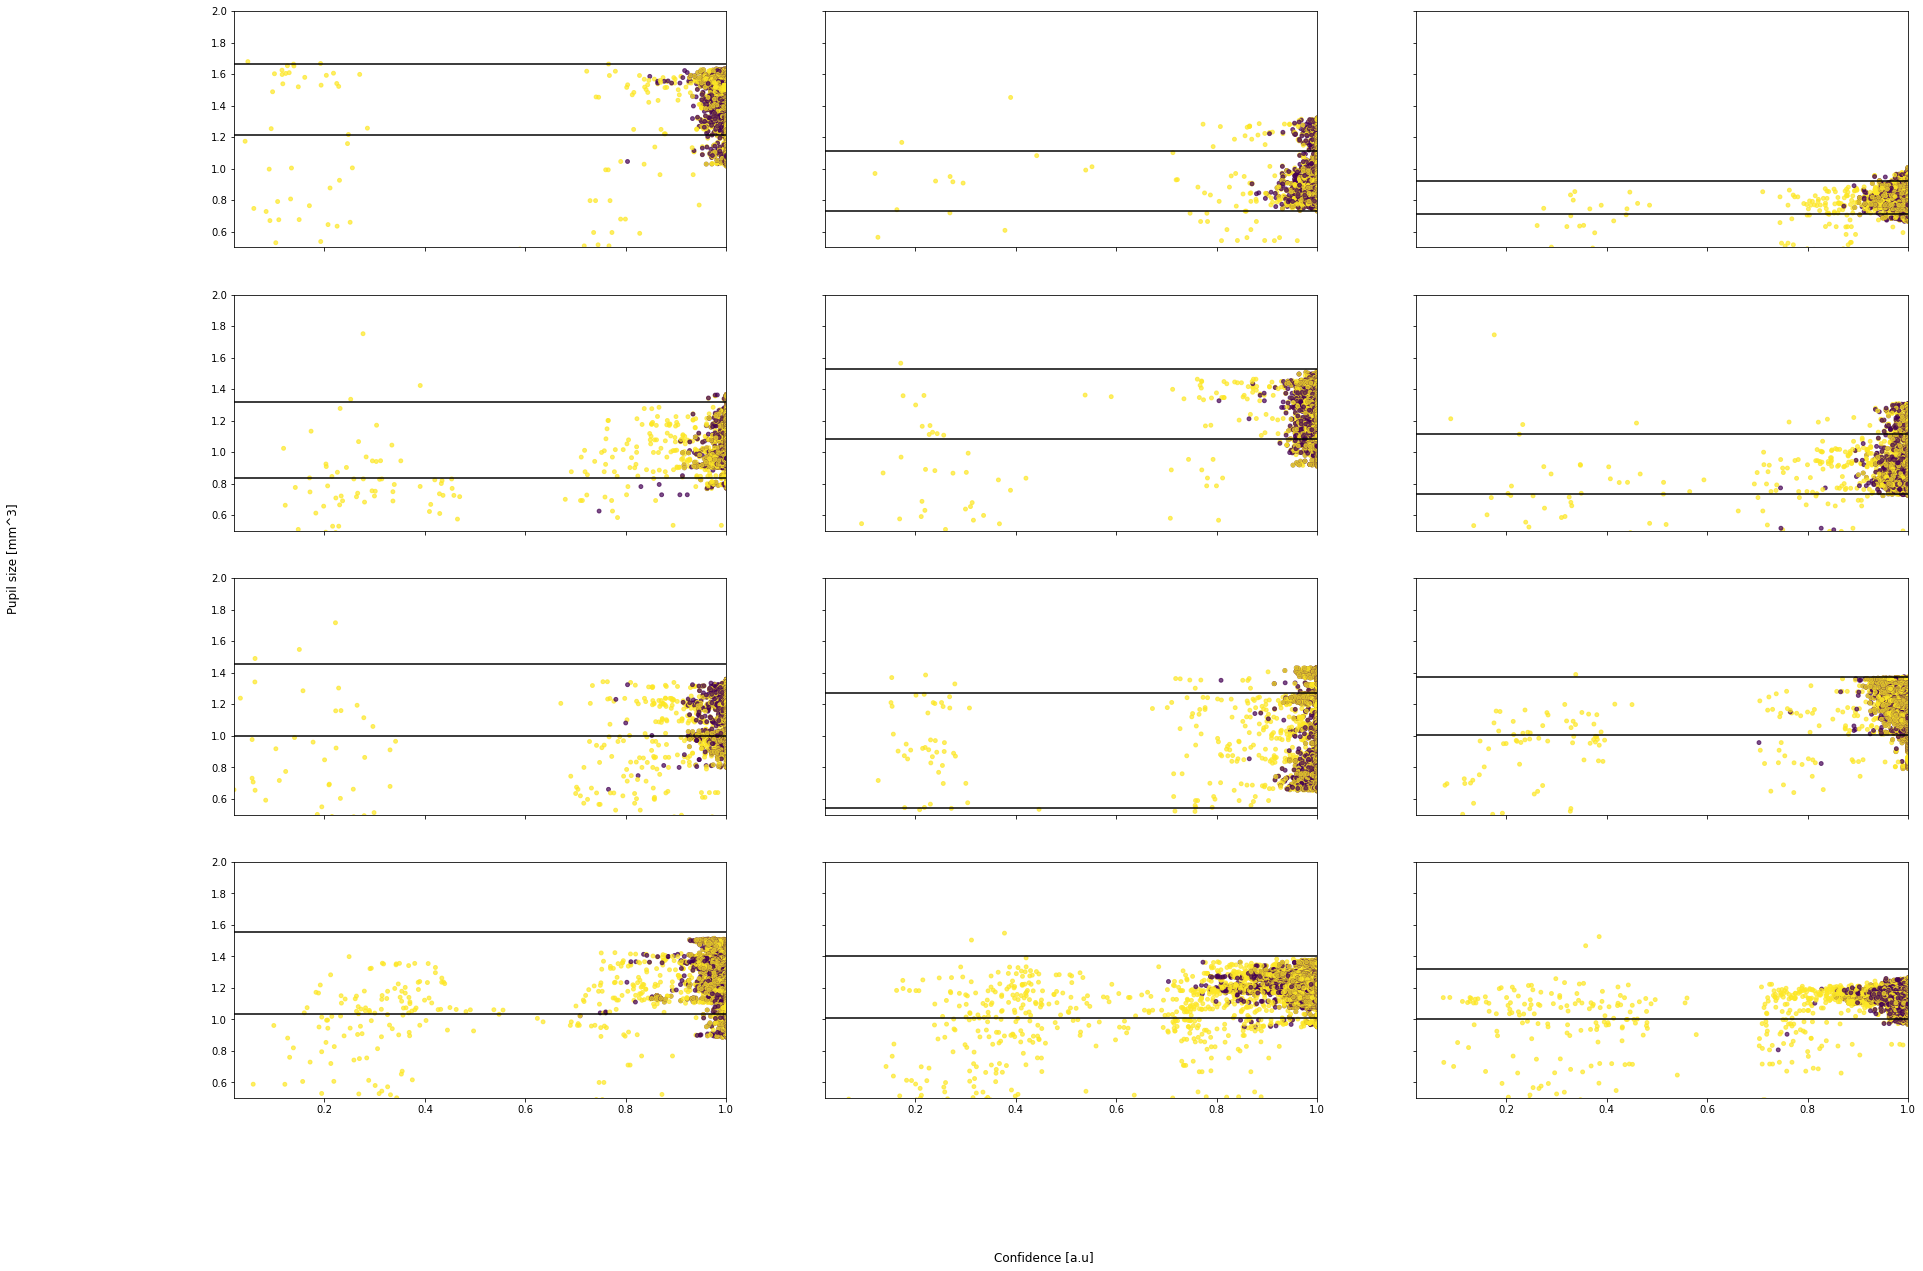

In [226]:
print(nms_ppl)

ch_oi = ['confidence', 'diameter1_3d']
idx_ch_oi = [nms_ppl.index(key) for key in ch_oi]

plt.rcParams['axes.xmargin'] = 0
fig,axs = plt.subplots(nrows=4,ncols=3,figsize=(30, 20),sharex=True, sharey=True)

arr = eps.data[idx_ch_oi,:,:]
for i,ax in zip(range(arr.shape[2]), axs.ravel()):
    x = eps.data[idx_ch_oi,:,i]
    x_ = pd.DataFrame(x.T).replace(0,np.nan)
    x_.columns = [ch_oi]

    # (3) delete diameter velocity outliers
    idx_out_vel, _ = delete_velocity_outliers(x[-1,:], whsize=10, n_mad=3, doplot=False)
    # (4) eyeblink detection (Hershman et al.)
    idx_out_blink, _ = blink_detection(x[-1,:], w_smooth=10, doplot=False)

    idx_all = list(idx_out_vel) + list(idx_out_blink)
    mask = np.zeros(len(x_))
    mask[idx_all] = 1
    x_["outlier"] = mask
    ax.scatter(x_['confidence'],x_['diameter1_3d'],s=15,c=x_['outlier'],alpha=0.7)
    ax.axhline([x_["diameter1_3d"].median(axis=0)-x_["diameter1_3d"].std(axis=0)*1.5],c='k')
    ax.axhline([x_["diameter1_3d"].median(axis=0)+x_["diameter1_3d"].std(axis=0)*1.5],c='k')
    ax.set_ylim(0.5, 2)
# set labels
fig.supxlabel('Confidence [a.u]')
fig.supylabel('Pupil size [mm^3]')

Max force is 5598 something


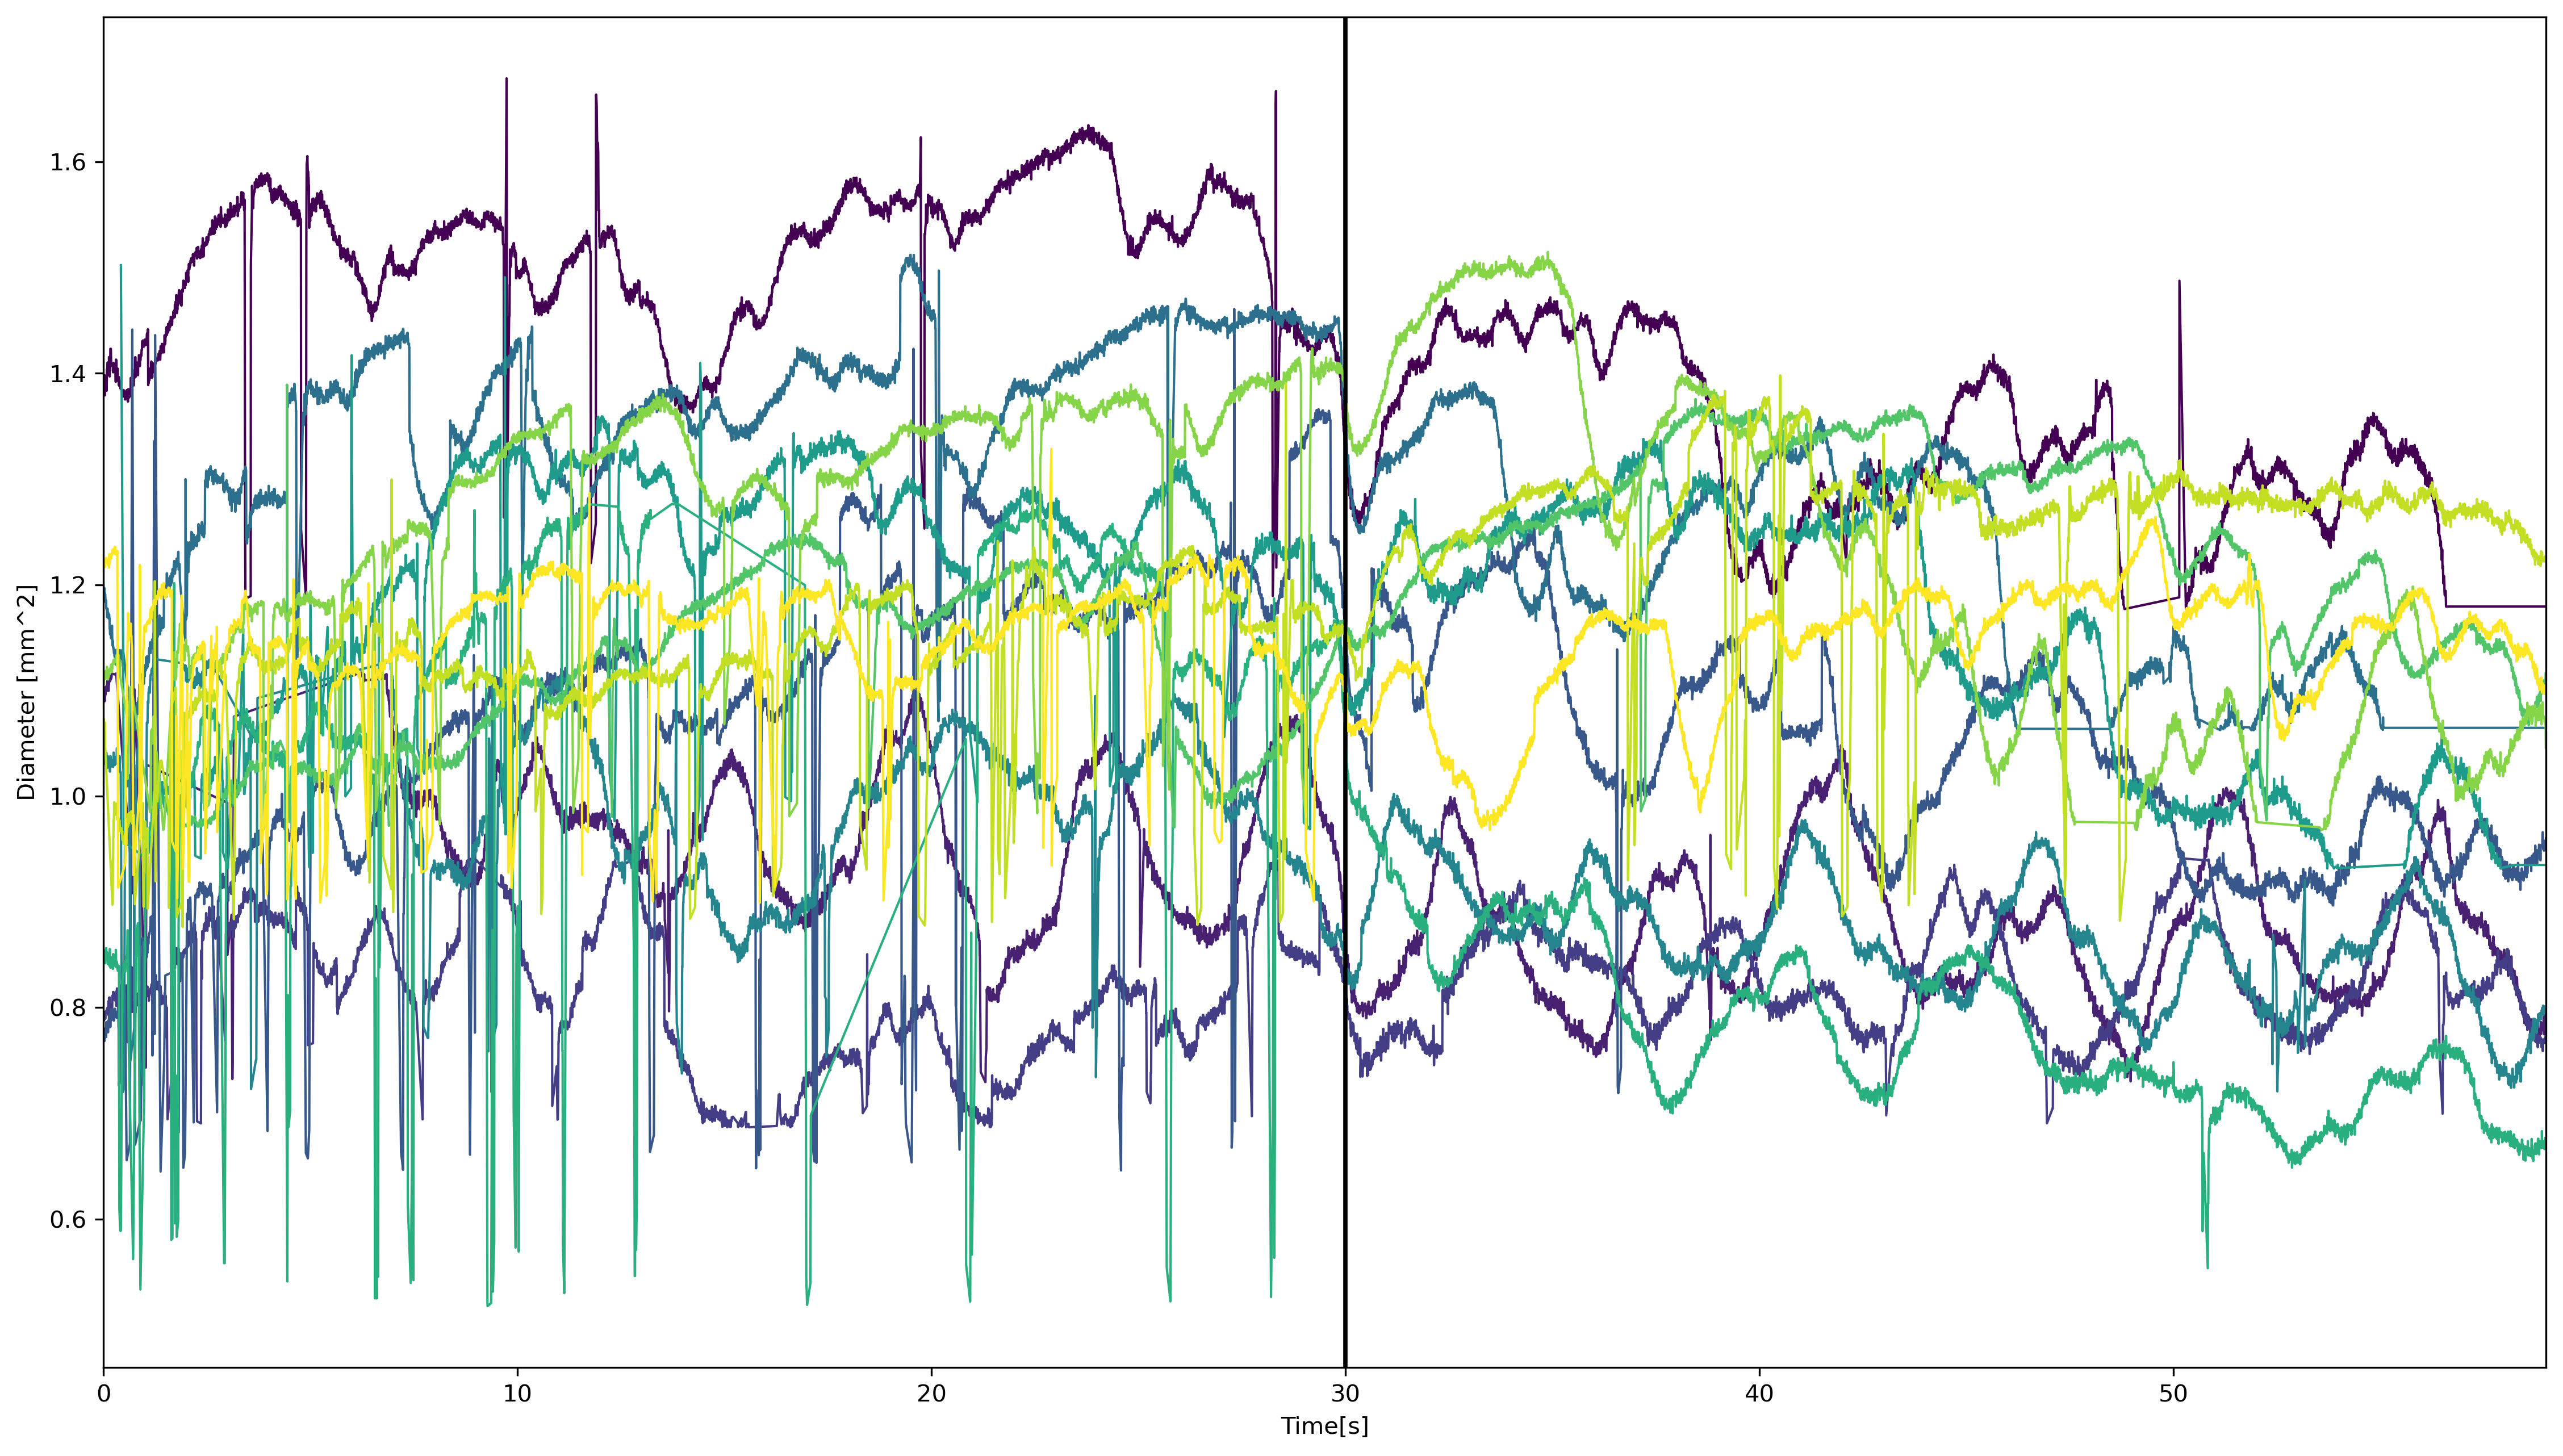

In [222]:
tmp_fnms = fnms[4:5]
for f in tmp_fnms:
    sub = SubjectData()
    sub.load_data(dir_rawdata,f)

    # extract ppl chn names
    ch_info = sub.eye["info"]["desc"][0]["channels"][0]
    nms_ppl = []
    for i,ch in enumerate(ch_info["channel"]):
        nms_ppl.append(ch_info["channel"][i].get('label')[0])

    # epoch data
    eps = Epochs(sub,sub.eye["time_series"],times=sub.eye["time_stamps"], events=sub.mrk, srate = sub.srate_ppl)
    idx_exp_start   = eps.events[eps.events["value"].str.match('block1')].index[0]
    eps.epoch('end_trial', idx_start=idx_exp_start,tmin=-60,tmax=0)
    eps.data[eps.data == 0] = np.nan

    # prep pupil data
    ch_oi = ['confidence', 'diameter1_3d']
    idx_ch_oi = [nms_ppl.index(key) for key in ch_oi]   


    colors = plt.cm.viridis(np.linspace(0,1,eps.data.shape[2]))

    for i in range(eps.data.shape[2]):
        ep = eps.data[idx_ch_oi,:,i]
        ep = pd.DataFrame(ep.T)
        ep.columns = [ch_oi]
        ep = ep.interpolate(method='linear',axis='rows')

        lower_thresh = ep["diameter1_3d"].median(axis=0)-ep["diameter1_3d"].std(axis=0)*1.5
        upper_thresh = ep["diameter1_3d"].median(axis=0)+ep["diameter1_3d"].std(axis=0)*1.5

        ep["diameter1_3d"] = np.where((ep.diameter1_3d < lower_thresh),np.nan,ep.diameter1_3d)
        ep["diameter1_3d"] = np.where((ep.diameter1_3d > upper_thresh),np.nan,ep.diameter1_3d)

        ep = ep.interpolate(method='linear',axis='rows')

        plt.plot(eps.times,ep["diameter1_3d"].to_numpy(),color=colors[i],linewidth=1)
        plt.axvline(30,c='k')
        plt.xlabel('Time[s]')
        plt.ylabel('Diameter [mm^2]')
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.set_dpi(300)


In [209]:
fnms[5]

'c305_archer_replicate.xdf'